### Load models


In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import rc

sys.path.append("../")
# Import dataloaders
import data_utils.ood_detection.cifar10 as cifar10
import data_utils.ood_detection.cifar100 as cifar100
import data_utils.ood_detection.lsun as lsun
import data_utils.ood_detection.svhn as svhn
import data_utils.ood_detection.mnist as mnist
import data_utils.ood_detection.tiny_imagenet as tiny_imagenet

# Network architectures
from net.lenet import lenet
from net.resnet import resnet50
from net.vgg import vgg16
from net.wide_resnet import wrn

from utils.gmm_utils import get_embeddings, gmm_evaluate, gmm_fit, maxp_evaluate, gmm_evaluate_with_perturbation, maxp_evaluate_with_perturbation
from metrics.uncertainty_confidence import entropy, logsumexp, confidence, sumexp, max

In [2]:
device = torch.device("cuda:0")
# Dataset params
dataset_num_classes = {"cifar10": 10, "cifar100": 100, "svhn": 10, "lsun": 10, "tiny_iamgenet": 200}

dataset_loader = {"cifar10": cifar10, "cifar100": cifar100, "svhn": svhn, "mnist": mnist, "lsun": lsun, "tiny_imagenet": tiny_imagenet}

# Mapping model name to model function
models = {
    "lenet": lenet,
    "resnet50": resnet50,
    "wide_resnet": wrn,
    "vgg16": vgg16,
}

model_to_num_dim = {"resnet18": 512, "resnet50": 2048, "resnet101": 2048, "resnet152": 2048, "wide_resnet": 640, "vgg16": 512}

batch_size = 64
dataset = "cifar10"
ood_dataset = "mnist"
dataset_root = "../data"
model = "resnet50"
saved_model_name = "../saved_models/resnet50_sn_3.0_mod_seed_1_best.model"

# Taking input for the dataset
num_classes = dataset_num_classes[dataset]
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=batch_size)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=batch_size)

In [3]:
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=batch_size,
    augment=True,
    val_seed=1,
    val_size=0.1,
)

#load model
print(f"load {saved_model_name}")
net = models[model](
    spectral_normalization=True,
    mod=True,
    num_classes=num_classes,
    temp=1.0,
).to(device)

net.load_state_dict(torch.load(str(saved_model_name)), strict=False)


load ../saved_models/resnet50_sn_3.0_mod_seed_1_best.model


<All keys matched successfully>

In [15]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)

def plot_density(results, binrange,title):

    plt.figure(figsize=(5, 3))
    plt.tight_layout()

    plt.hist(results[0],density=True,color='r',range=binrange,bins=100,alpha=0.5,label="org")
    plt.hist(results[1],density=True,color='b',range=binrange,bins=100,alpha=0.5,label="ood")

    plt.xlabel('Log Density', fontsize=12)
    plt.ylabel('Fraction', fontsize=12)
    plt.title(label=title)
    plt.legend()

if not  os.path.exists("pngs"):
    os.makedirs("pngs")


### Compute logits

In [13]:
logits, _ = maxp_evaluate(net, test_loader, device, num_classes, storage_device=device)
ood_logits, _ = maxp_evaluate(net, ood_test_loader, device, num_classes, storage_device=device)
logits2, _ =  maxp_evaluate_with_perturbation(net,test_loader,device,num_classes,storage_device=device)
ood_logits2, _ =  maxp_evaluate_with_perturbation(net,ood_test_loader,device,num_classes,storage_device=device)

100%|██████████| 157/157 [00:46<00:00,  3.39it/s]


In [17]:
logits = logsumexp(logits).cpu().numpy()
logits2 = logsumexp(logits2).cpu().numpy()
ood_logits = logsumexp(ood_logits).cpu().numpy()
ood_logits2 = logsumexp(ood_logits2).cpu().numpy()

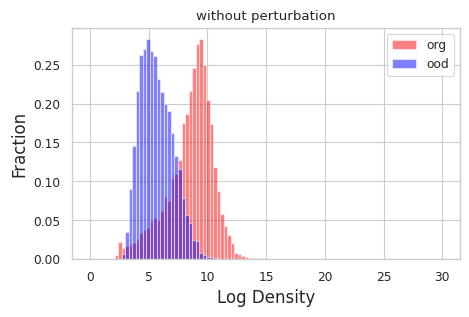

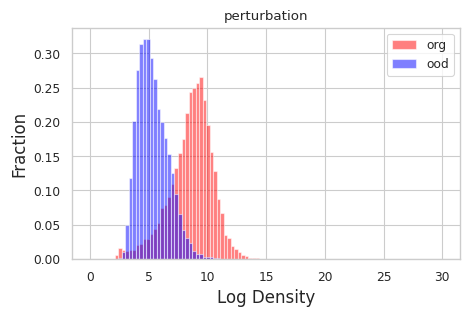

In [20]:
plot_density([logits,ood_logits], binrange=[0, 30], title="without perturbation")
plt.savefig('pngs/logits_hist.png', bbox_inches='tight')
plot_density([logits2,ood_logits2], binrange=[0, 30], title="perturbation")
plt.savefig('pngs/logits_hist2.png', bbox_inches='tight')

### Compute feature density


In [4]:
embeddings, labels = get_embeddings(
    net,
    train_loader,
    num_dim=model_to_num_dim[model],
    dtype=torch.double,
    device=device,
    storage_device=device,
)
gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)
logits, labels = gmm_evaluate(
    net,
    gaussians_model,
    test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)
ood_logits, ood_labels = gmm_evaluate(
    net,
    gaussians_model,
    ood_test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)

logits2, labels2 = gmm_evaluate_with_perturbation(
    net,
    gaussians_model,
    test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)
ood_logits2, ood_labels2 = gmm_evaluate_with_perturbation(
    net,
    gaussians_model,
    ood_test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)

get embeddings from dataloader...


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


In [5]:
logp = logsumexp(logits).cpu().numpy()
logp2 = logsumexp(logits2).cpu().numpy()
ood_logp = logsumexp(ood_logits).cpu().numpy()
ood_logp2 = logsumexp(ood_logits2).cpu().numpy()

### Plot feature density


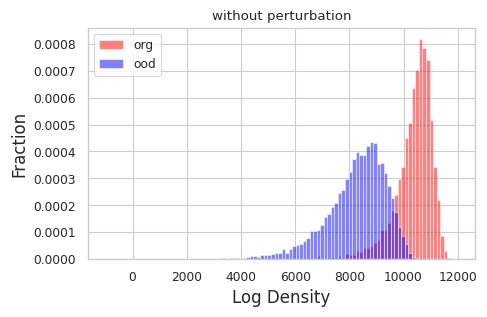

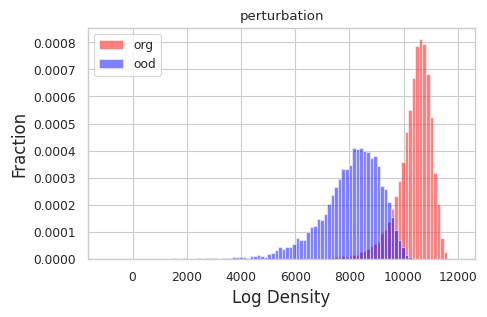

In [10]:
# data = np.concatenate((logp, ood_logp))
# categories = np.concatenate((np.zeros_like(logp, dtype=np.int8), np.ones_like(ood_logp, dtype=np.int8)))

# df = pd.DataFrame(dict(logdensity=, category=categories))
plot_density([logp,ood_logp], binrange=[-1000, 12000], title="without perturbation")
plt.savefig('pngs/logdensity_hist.png', bbox_inches='tight')
plot_density([logp2,ood_logp2], binrange=[-1000, 12000], title="perturbation")
plt.savefig('pngs/logdensity_hist2.png', bbox_inches='tight')

### Calibration Plot for Dirty-MNIST


In [35]:
from metrics.classification_metrics import test_classification_net
from metrics.calibration_metrics import reliability_plot
from utils.temperature_scaling import ModelWithTemperature

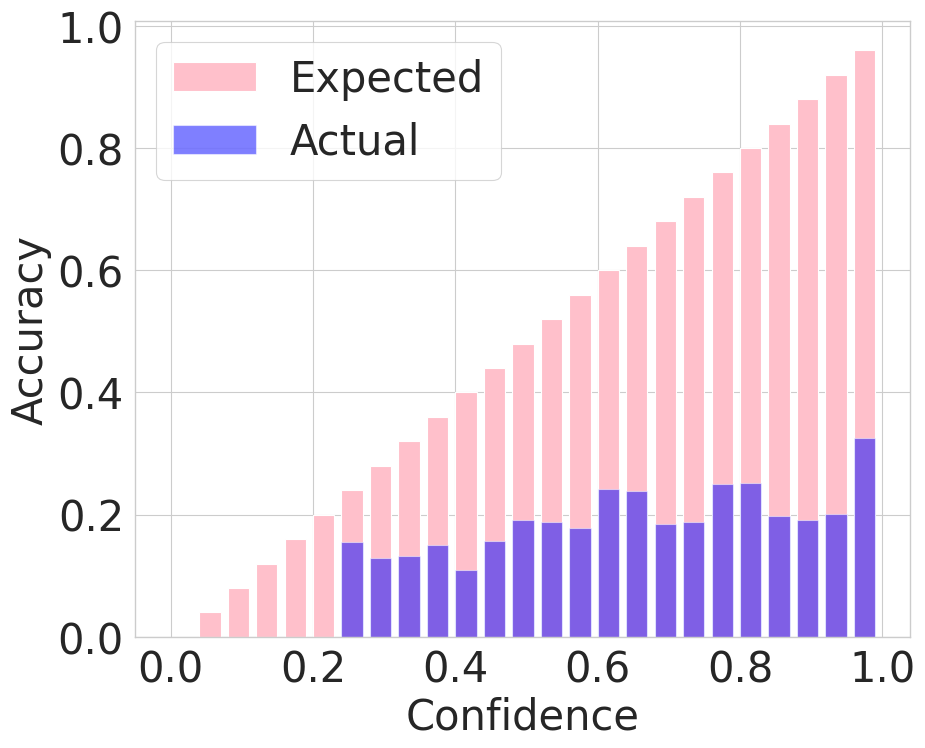

In [39]:
# Reliability plot 
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(net, test_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="resnet50")

Before temperature - NLL: 4.788, ECE: 0.567
Optimal temperature: 6.300
After temperature - NLL: 2.153, ECE: 0.035


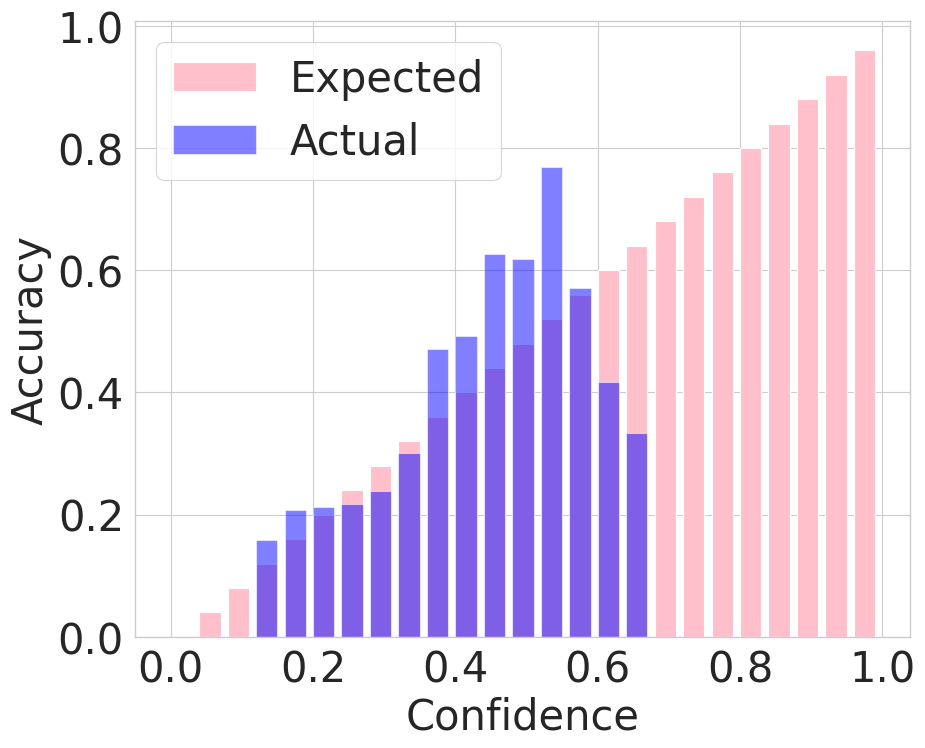

In [40]:
# Reliability plot for  post temp scaling
temp_model = ModelWithTemperature(net,device)
temp_model.set_temperature(test_loader)
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(temp_model, test_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="resnet50")